# Classification
This file includes code which classifies text chunks as (Austen, Cervantes, Sturluson, God and Dostoevsky).
The training data is text chunks from their respective works _Pride and predjudice_, _King James Bible_ (Genesis through Deuteronomy), _Don Quixote_ (Volume I), _Heimskringla_ and _Crime and punishment_. We obtain the texts from the Gutenberg Project.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import skorch
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from textdataset_classification import TextDataset
from neural_net import NeuralNet

Training the model:

In [2]:
def training_model(dataloader, model, loss_fn, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        # setting the model to train mode
        model.train()
        
        for (X, y) in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()           # resets the gradients

        if epoch % 1 == 0:
            loss = loss.item()
            print(f"Epoch {epoch+1:>4f}      loss: {loss:>7f}")

Test loop:

In [3]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode 
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():           # gradient computation excluded, unnecessary
        for X, y in dataloader:
            pred = model(X)

            all_preds.extend(pred.argmax(1).tolist())
            all_labels.extend(y.tolist())

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return all_preds, all_labels, correct

`skorch` implementation of neural net which makes the `PyTorch`neural net compatible with the `scikit-learn` API

In [4]:
net = skorch.NeuralNetClassifier(
    NeuralNet,
    max_epochs=50,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam
)

### Loading in the data

In [17]:
X = np.load('Data/text_data_sentences.npy')
y = np.load('Data/labels_sentences.npy')

### Gridsearch for optimal learning rate

In [ ]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

param_grid = {
    'optimizer__lr': [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(estimator=net, param_grid=param_grid, n_jobs=1, cv=5)
grid_result = grid.fit(X_train, y_train)

print(grid_result.cv_results_['mean_test_score'])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4173       0.8700        1.2153  0.2620
      2        1.0638       0.8781        0.9274  0.2334
      3        0.8251       0.8975        0.7360  0.2850
      4        0.6666       0.8969        0.6084  0.2539
      5        0.5582       0.8962        0.5204  0.2434
      6        0.4805       0.9069        0.4543  0.2505
      7        0.4232       0.9094        0.4063  0.2496
      8        0.3801       0.9100        0.3690  0.2503
      9        0.3462       0.9087        0.3408  0.2535
     10        0.3195       0.9119        0.3182  0.2439
     11        0.2980       0.9137        0.2992  0.2165
     12        0.2794       0.9131        0.2841  0.2335
     13        0.2640       0.9169        0.2714  0.2538
     14        0.2512       0.9181        0.2605  0.2458
     15        0.2396       0.9187        0.2501  0.2333
     16        0.2297       0.9

Accuracy: [0.937, 0.9379, 0.9401]

### Accuracy as a function of Dataset size

In [ ]:
numbers = np.arange(5, 101, 5)
accuracy = np.zeros(len(numbers))

# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

net.fit(X_train, y_train)

indices = int(X_train.shape[0]/10) * numbers

for idx, per in enumerate(indices):
    accuracy[idx] = np.mean(cross_val_score(net, X_train[:per], y_train[:per], scoring='accuracy', cv=10))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3501       0.9080        0.2616  0.3109
      2        0.1604       0.9270        0.2152  0.3504
      3        0.1187       0.9260        0.2007  0.3670
      4        0.0915       0.9190        0.2468  0.3831
      5        0.0713       0.9380        0.2151  0.3494
      6        0.0482       0.9295        0.2328  0.3208
      7        0.0346       0.9345        0.2417  0.3459
      8        0.0182       0.9380        0.2640  0.3424
      9        0.0090       0.9360        0.2652  0.3443
     10        0.0045       0.9385        0.2811  0.3315
     11        0.0026       0.9400        0.2885  0.3577
     12        0.0019       0.9375        0.2956  0.3218
     13        0.0015       0.9385        0.2989  0.3086
     14        0.0013       0.9385        0.3058  0.3251
     15        0.0011       0.9385        0.3096  0.3831
     16        0.0009       0.9

In [10]:
np.save('Data/results_accuracy_sentence.npy', accuracy)

### Accuracy as a function of Chunk Size and Dataset Size

In [ ]:
chunk_sizes = ['50', '100', '150']
numbers = np.arange(5, 101, 5)
accuracy = np.zeros((len(chunk_sizes), len(numbers)))

for idx, chunk in enumerate(chunk_sizes):

    X = np.load('text_data' + chunk + '.npy')
    y = np.load('labels' + chunk + '.npy')

    # splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

    y_train = torch.from_numpy(y_train).long()
    y_test = torch.from_numpy(y_test).long()

    net.fit(X_train, y_train)

    indices = int(X_train.shape[0]/10) * numbers

    for idy, per in enumerate(indices):
        accuracy[idx, idy] = np.mean(cross_val_score(net, X_train[:per], y_train[:per], scoring='accuracy', cv=10))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2063       0.8768        0.8039  0.2270
      2        0.5865       0.9219        0.4444  0.2020
      3        0.3626       0.9307        0.3148  0.2000
      4        0.2722       0.9374        0.2558  0.1790
      5        0.2258       0.9462        0.2201  0.2030
      6        0.1977       0.9486        0.1985  0.1920
      7        0.1788       0.9514        0.1814  0.1800
      8        0.1645       0.9521        0.1697  0.1824
      9        0.1539       0.9532        0.1613  0.1820
     10        0.1454       0.9543        0.1534  0.1900
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4125       0.7879        1.2091  0.1025
      2        1.0157       0.8638        0.8416  0.1370
      3        0.7109       0.9131        0.6097  0.0835
      4        0.5277       0.9

### Measuring performance on test dataset and creating confusion matrix

#### Sentences

In [18]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

y_test = torch.from_numpy(y_test).long()
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

model = torch.load('Data/sentences_model.pt')
loss_fn = nn.CrossEntropyLoss()

predictions, labels, acc = test_loop(dl_test, model, loss_fn)

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.973417 



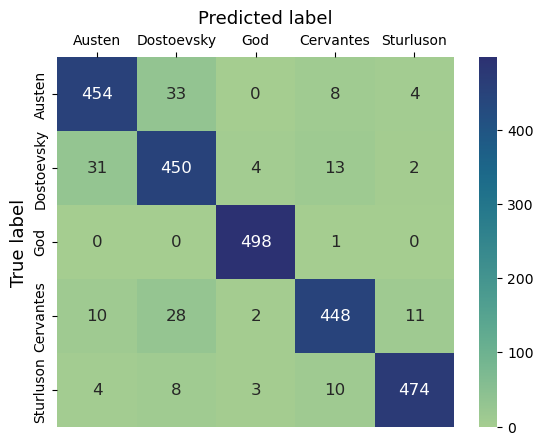

In [19]:
# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":12},
            fmt=".0f",
            xticklabels=['Austen', 'Dostoevsky', 'God', 'Cervantes', 'Sturluson'],
            yticklabels=['Austen', 'Dostoevsky', 'God', 'Cervantes', 'Sturluson'],
            cmap='crest')
plt.ylabel('True label', fontsize=13)
#plt.title('Confusion Matrix', fontsize=17, pad=20, loc='center')
ax.set(xlabel="", ylabel="True label")
ax.xaxis.tick_top()

plt.gca().figure.text(0.45, 0.95, 'Predicted label', ha='center', fontsize=13)
plt.show()

#### Chunk size 150

In [8]:
X = np.load('Data/text_data150.npy')
y = np.load('Data/labels150.npy')

In [9]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

y_test = torch.from_numpy(y_test).long()
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

model = torch.load('Data/150_chunksize_model.pt')
loss_fn = nn.CrossEntropyLoss()

predictions, labels, acc = test_loop(dl_test, model, loss_fn)

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.911967 



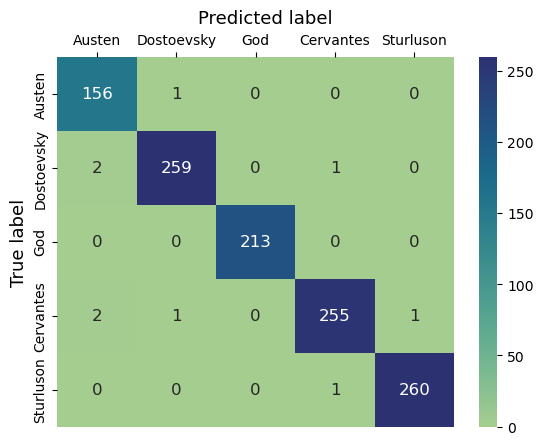

In [13]:
# Compute the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":12},
            fmt=".0f",
            xticklabels=['Austen', 'Dostoevsky', 'God', 'Cervantes', 'Sturluson'],
            yticklabels=['Austen', 'Dostoevsky', 'God', 'Cervantes', 'Sturluson'],
            cmap='crest')
plt.ylabel('True label', fontsize=13)
#plt.title('Confusion Matrix', fontsize=17, pad=20, loc='center')
ax.set(xlabel="", ylabel="True label")
ax.xaxis.tick_top()

plt.gca().figure.text(0.45, 0.95, 'Predicted label', ha='center', fontsize=13)
plt.show()

### Testing performance on other books by the same authors for chunk size 150

In [7]:
folder = ".."
subfolder = "Texts"
filenames = ['sense_and_sensibility', 'brother_karamazov', 'nt_god', 'don_quixote_volume2', 'additional_sagas']
filepaths = [os.path.join(folder, subfolder, filename) for filename in filenames]

data = [np.load(filepath+'.npy') for filepath in filepaths]
lengths = [len(author) for author in data]

X = np.vstack(data)
y = np.repeat(np.arange(5), lengths) # improved target vector

y = torch.from_numpy(y).long()

dataset_add = TextDataset(torch.tensor(X), y)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_add = DataLoader(dataset_add, batch_size=batch_size, shuffle=True, drop_last=True)

predictions, labels, acc = test_loop(dl_add, model, loss_fn)

Test Error: 
 Accuracy: 97.9%, Avg loss: 0.922526 



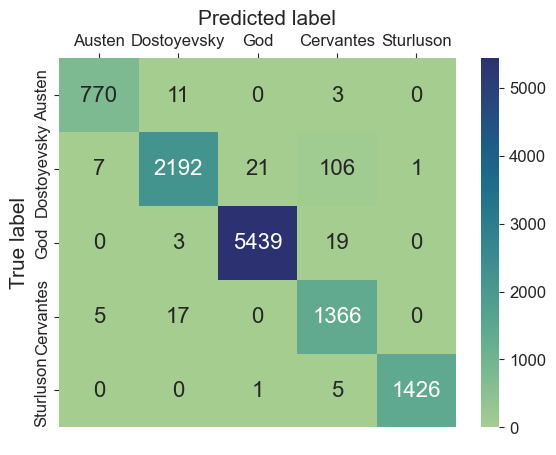

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(labels, predictions)

# plotting parameters
sns.set_style('whitegrid')
sns.set_palette('muted')
plt.rc('xtick', labelsize=12)  # Set x-tick label size
plt.rc('ytick', labelsize=12)  # Set y-tick label size

# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":16},
            fmt=".0f",
            xticklabels=['Austen', 'Dostoevsky', 'God', 'Cervantes', 'Sturluson'],
            yticklabels=['Austen', 'Dostoevsky', 'God', 'Cervantes', 'Sturluson'],
            cmap='crest')
plt.ylabel('True label', fontsize=15)
ax.set(xlabel=" ", ylabel="True label")
ax.xaxis.tick_top()
ax.yaxis.tick_left()

plt.gca().figure.text(0.45, 0.95, 'Predicted label', ha='center', fontsize=15)
plt.show()